In [ ]:
import yfinance as yahooFinance
import pandas as pd
import datetime
import os
import re
import numpy as np
import collections.abc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels.api as sm
from joblib import dump, load
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm
import itertools

# Global plot params plt.rcParams to make plots look preaty
plt.rc('figure', figsize=(8.5, 5.5))
plt.rc('font', size=7)
plt.rc('axes', facecolor='#ECECF5')
plt.rc('axes', edgecolor='white')
plt.rc('axes', grid=True)
plt.rc('xtick', bottom=False)
plt.rc('ytick', left=False)
plt.rc('grid', color='white')
plt.rc('lines', linewidth=1)
plt.rc('legend', frameon=False)

In [387]:
def log_returns(dataFrame):
    data = dataFrame.copy()
    data["log_returns"] = np.log(data.Close.div(data.Close.shift(1)))
    data["creturns"] = data.log_returns.cumsum().apply(np.exp)
    data.log_returns.iat[0] = 0
    data.creturns.iat[0] = 1
    return data

def download_stock_data(tickers, index_ticker):
    today_date = datetime.date.today()
    startDate = datetime.datetime(today_date.year - TRAIN_YEARS, today_date.month, 1)
    endDate = datetime.datetime(today_date.year, today_date.month, 1)

    le_tickers = len(tickers)
    data_arr = np.empty(le_tickers, dtype=pd.DataFrame)
    i = 0
    for ticker in tqdm(tickers):
        GetInformation = yahooFinance.Ticker(ticker)
        df = GetInformation.history(start=startDate, end=endDate, interval='1mo')
        df = df.dropna().copy()
        df = log_returns(df)
        df = df.dropna().copy()
        data_arr[i] = df[['log_returns']].copy()
        i += 1
    
    GetInformation = yahooFinance.Ticker(index_ticker)
    df_index = GetInformation.history(start=startDate, end=endDate, interval='1mo')
    df_index = df_index.dropna().copy()
    df_index = log_returns(df_index)
    df_index = df_index.dropna().copy()
    df_index = df_index[['log_returns']].copy()
    
    sub_cluster = pd.concat([ data.log_returns for data in data_arr ], axis=1)
    sub_cluster.columns = tickers
    sub_cluster = sub_cluster.iloc[1:,:].copy()
    df_index = df_index.iloc[1:,:].copy()
    print(f"Downloaded {len(sub_cluster.columns)} assets and index {index_ticker}. In timeframe {startDate.year}.{startDate.month} - {endDate.year}.{endDate.month}")
    return sub_cluster, df_index

def get_weights_mx(size=15):
    w_list = list()
    half_size = int(size/2)
    
    x = np.arange(0, size, 1)
    for i in np.arange(-1,1,0.2):
        y = i * (x - half_size) + half_size + 1
        y = y / np.sum(y)
        w_list.append(y)
        
    y = -1 * (x - half_size) + half_size + 1
    y = y / np.sum(y)
    for i in np.arange(0, size - 1, 1):
        y = np.roll(y, 1)
        w_list.append(y)
        
    y = (x - half_size) + half_size + 1
    y = y / np.sum(y)
    for i in np.arange(0, size - 1, 1):
        y = np.roll(y, 1)
        w_list.append(y)
        
    result = np.array(w_list)
    print(f"Generated weights matrix of shape {result.shape}")
        
    return result

def historicalBeta(returns, market_returns):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the beta of the stock
    """
    if isinstance(returns, pd.Series):
        beta, alpha = np.polyfit(market_returns, returns, 1)
        return beta

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalBeta, market_returns=market_returns)

    else:
        raise TypeError("Expected returns to be dataframe or series")
        
def historicalVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the percentile of the distribution at the given alpha confidence level
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def historicalCVaR(returns, alpha=5):
    """
    Read in a pandas dataframe of returns / a pandas series of returns
    Output the CVaR for dataframe / series
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= historicalVaR(returns, alpha=alpha)
        return np.abs(returns[belowVaR].mean())

    # A passed user-defined-function will be passed a Series for evaluation.
    elif isinstance(returns, pd.DataFrame):
        return returns.aggregate(historicalCVaR, alpha=alpha)

    else:
        raise TypeError("Expected returns to be dataframe or series")

def compose_data(sub_cluster, sub_cluster_market, weights_matrix, ticker_combinations):
    sub_cluster = sub_cluster.copy()
    sub_cluster_market = sub_cluster_market.copy()
    
    composed_data = list()
    tickers_res = list()
    
    weights_range = weights_matrix.shape[1]
    weights_size = weights_matrix.shape[0]
    
    f1_sub_cluster_market = sub_cluster_market.iloc[:,:].copy()
    f2_sub_cluster_market = sub_cluster_market.iloc[(TRAIN_YEARS - 2) * YEAR_PERIODS:,:].copy()
    f3_sub_cluster_market = sub_cluster_market.iloc[(TRAIN_YEARS - 1) * YEAR_PERIODS:,:].copy()
    
    x3_arr_mean_market = np.zeros(3)
    x3_arr_std_market = np.zeros(3)
    x3_arr_sharp_market = np.zeros(3)
    x3_arr_var_market = np.zeros(3)
    x3_arr_cvar_market = np.zeros(3)
    
    x3_arr_mean_market = np.array([f1_sub_cluster_market.log_returns.mean(),
                          f2_sub_cluster_market.log_returns.mean(),
                          f3_sub_cluster_market.log_returns.mean()])
    x3_arr_std_market = np.array([f1_sub_cluster_market.log_returns.std(),
                          f2_sub_cluster_market.log_returns.std(),
                          f3_sub_cluster_market.log_returns.std()])
    x3_arr_sharp_market = x3_arr_mean_market / x3_arr_std_market
    x3_arr_var_market = np.array([historicalVaR(f1_sub_cluster_market.log_returns),
                          historicalVaR(f2_sub_cluster_market.log_returns),
                          historicalVaR(f3_sub_cluster_market.log_returns)])
    x3_arr_cvar_market = np.array([historicalCVaR(f1_sub_cluster_market.log_returns),
                          historicalCVaR(f2_sub_cluster_market.log_returns),
                          historicalCVaR(f3_sub_cluster_market.log_returns)])
    
    for p in tqdm(range(0, len(ticker_combinations))):
        column_indecies = ticker_combinations[p]
        forp_sub_cluster = sub_cluster.loc[:, column_indecies].copy()
        f1_sub_cluster = forp_sub_cluster.iloc[:,:].copy()
        f2_sub_cluster = forp_sub_cluster.iloc[(TRAIN_YEARS - 2) * YEAR_PERIODS:,:].copy()
        f3_sub_cluster = forp_sub_cluster.iloc[(TRAIN_YEARS - 1) * YEAR_PERIODS:,:].copy()
        
        # Calculate weight independent features. 
        # 3x mean (market) 3x std (market) 3x sharp (market) 3x VaR (market) 3x CVaR (market) 3x beta 
        
        x3_arr_mean = np.zeros(weights_range * 3)
        x3_arr_std = np.zeros(weights_range * 3)
        x3_arr_sharp = np.zeros(weights_range * 3)
        x3_arr_var = np.zeros(weights_range * 3)
        x3_arr_cvar = np.zeros(weights_range * 3)
        x3_arr_beta = np.zeros(weights_range * 3)
        
        f1_sub_cluster_mean = f1_sub_cluster.mean()
        f2_sub_cluster_mean = f2_sub_cluster.mean()
        f3_sub_cluster_mean = f3_sub_cluster.mean()
        
        f1_sub_cluster_std = f1_sub_cluster.std()
        f2_sub_cluster_std = f2_sub_cluster.std()
        f3_sub_cluster_std = f3_sub_cluster.std()
        
        f1_sub_cluster_var = historicalVaR(f1_sub_cluster)
        f2_sub_cluster_var = historicalVaR(f2_sub_cluster)
        f3_sub_cluster_var = historicalVaR(f3_sub_cluster)
        
        f1_sub_cluster_cvar = historicalCVaR(f1_sub_cluster)
        f2_sub_cluster_cvar = historicalCVaR(f2_sub_cluster)
        f3_sub_cluster_cvar = historicalCVaR(f3_sub_cluster)
        
        f1_sub_cluster_beta = historicalBeta(f1_sub_cluster, f1_sub_cluster_market.log_returns)
        f2_sub_cluster_beta = historicalBeta(f2_sub_cluster, f2_sub_cluster_market.log_returns)
        f3_sub_cluster_beta = historicalBeta(f3_sub_cluster, f3_sub_cluster_market.log_returns)
        
        wi = 0
        for w in range(0, weights_range):
            w = w * 3
            x3_arr_mean[w] = f1_sub_cluster_mean[wi]
            x3_arr_mean[w+1] = f2_sub_cluster_mean[wi]
            x3_arr_mean[w+2] = f3_sub_cluster_mean[wi]
            x3_arr_std[w] = f1_sub_cluster_std[wi]
            x3_arr_std[w+1] = f2_sub_cluster_std[wi]
            x3_arr_std[w+2] = f3_sub_cluster_std[wi]
            x3_arr_sharp[w] = f1_sub_cluster_mean[wi] / f1_sub_cluster_std[wi]
            x3_arr_sharp[w+1] = f2_sub_cluster_mean[wi] / f2_sub_cluster_std[wi]
            x3_arr_sharp[w+2] = f3_sub_cluster_mean[wi] / f3_sub_cluster_std[wi]
            x3_arr_var[w] = f1_sub_cluster_var[wi]
            x3_arr_var[w+1] = f2_sub_cluster_var[wi]
            x3_arr_var[w+2] = f3_sub_cluster_var[wi]
            x3_arr_cvar[w] = f1_sub_cluster_cvar[wi]
            x3_arr_cvar[w+1] = f2_sub_cluster_cvar[wi]
            x3_arr_cvar[w+2] = f3_sub_cluster_cvar[wi]
            x3_arr_beta[w] = f1_sub_cluster_beta[wi]
            x3_arr_beta[w+1] = f2_sub_cluster_beta[wi]
            x3_arr_beta[w+2] = f3_sub_cluster_beta[wi]
            wi += 1
        
        independent_features = np.array([*x3_arr_mean,
               *x3_arr_mean_market,
               *x3_arr_std,
               *x3_arr_std_market,
               *x3_arr_sharp,
               *x3_arr_sharp_market,
               *x3_arr_var,
               *x3_arr_var_market,
               *x3_arr_cvar,
               *x3_arr_cvar_market,
               *x3_arr_beta])
            
        # Calculate weight dependent features. 
        # 3x portfolio_mean portfolio_std portfolio_sharp
        # next year portfolio_sharp
        for s in range(0, weights_size):
            weights = weights_matrix[s].copy()
            s1_mean = np.sum(f1_sub_cluster_mean * weights)
            s1_std = np.sqrt(np.dot(weights.T, np.dot(f1_sub_cluster.cov(), weights)))
            s1_sharp = s1_mean/s1_std
            
            s2_mean = np.sum(f2_sub_cluster_mean * weights)
            s2_std = np.sqrt(np.dot(weights.T, np.dot(f2_sub_cluster.cov(), weights)))
            s2_sharp = s2_mean/s2_std
            
            s3_mean = np.sum(f3_sub_cluster_mean * weights)
            s3_std = np.sqrt(np.dot(weights.T, np.dot(f3_sub_cluster.cov(), weights)))
            s3_sharp = s3_mean/s3_std
            
            row = np.array([*weights, 
                            *independent_features, 
                            s1_mean, 
                            s1_std, 
                            s1_sharp, 
                            s2_mean,
                            s2_sharp,
                            s3_mean,
                            s3_std,
                            s3_sharp])
            composed_data.append(row)
            tickers_res.append(ticker_combinations[p])
            
    return np.array(composed_data), np.array(tickers_res)

def get_graph(ticks, weights, title):
    fig, ax = plt.subplots(figsize=(11,2))
    sorted_i = np.argsort(weights)[::-1]
    weights = weights[sorted_i]
    ticks = ticks[sorted_i]
    ax.bar(np.arange(len(weights)), weights*100, color='pink')
    ax.set_title(title, fontdict={'fontsize': 15})
    ax.set_xticks(np.arange(len(ticks)), labels=ticks, fontsize = 8)
    ax.grid(visible=False, axis='both')
    ax.set_ylabel('Weights %', fontsize=10)
    for x in range(0, len(weights)):
        text = ax.text(x, 1, f"{weights[x]*100:.1f}%", ha='center', va='center', color='midnightblue', fontsize=9)
    plt.show()
        
def plt_fnd(row, ticks, portfolio_f_sharp):
    arr_means = [
        row[15]* 12,
        row[18]* 12,
        row[21]* 12,
        row[24]* 12,
        row[27]* 12,
        row[30]* 12,
        row[33]* 12,
        row[36]* 12,
        row[39]* 12,
        row[42]* 12,
        row[45]* 12,
        row[48]* 12,
        row[51]* 12,
        row[54]* 12,
        row[57]* 12
    ] 
    arr_std = [
        row[62]* 12,
        row[65]* 12,
        row[68]* 12,
        row[71]* 12,
        row[74]* 12,
        row[77]* 12,
        row[80]* 12,
        row[83]* 12,
        row[86]* 12,
        row[89]* 12,
        row[92]* 12,
        row[95]* 12,
        row[98]* 12,
        row[101]* 12,
        row[104]* 12
    ] 
    portfolio_mean = row[-8] * 12
    portfolio_std = row[-7] * 12
    portfolio_sharp = row[-6] * 12
    cvar = np.dot(historicalCVaR(sub_cluster[ticks]), row[:PORTFOLIO_SIZE])
    beta = np.dot(historicalBeta(sub_cluster[ticks], data_index.log_returns), row[:PORTFOLIO_SIZE])
    
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    axs[0].set_xlabel('Risk (std)', fontsize = 10)
    axs[0].set_ylabel('Mean Return', fontsize = 10)
    axs[0].set_title(f"Historical Mean-Variance Analysis")
    for i in range(0, len(arr_means)):
        axs[0].text(arr_std[i], arr_means[i]-0.01, ticks[i], ha='center', va='top', size=8)
        axs[0].plot(arr_std[i], arr_means[i], 'o-', color='royalblue')
        
    today_date = datetime.date.today()
    startDate = datetime.datetime(today_date.year - TRAIN_YEARS, today_date.month, 1)
    endDate = datetime.datetime(today_date.year, today_date.month, 1)
    
    axs[1].axis('off')
    axs[1].text(0.1, 1, f"Historical portfolio values {startDate.year}.{startDate.month} - {endDate.year}.{endDate.month}", ha='left', va='center', size=15, wrap=True, fontfamily='Arial', fontweight='medium', color='dimgray')
    axs[1].text(0.2, 0.9, f"Mean returns: {portfolio_mean:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')
    axs[1].text(0.2, 0.8, f"(std) risk: {portfolio_std:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')
    axs[1].text(0.2, 0.7, f"Sharp ratio: {portfolio_sharp:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')
    axs[1].text(0.2, 0.6, f"CVaR: {cvar:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')
    axs[1].text(0.2, 0.5, f"Beta: {beta:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')
    
    axs[1].text(0.1, 0.4, f"Predicted", ha='left', va='center', size=15, wrap=True, fontfamily='Arial', fontweight='medium', color='dimgray')
    axs[1].text(0.2, 0.3, f"Sharp ratio: {portfolio_f_sharp*12:.4f}", ha='left', va='center', size=13, wrap=True, fontfamily='Arial')

    plt.show()
    
def normalize(predictors):
    ret = predictors - np.mean(predictors)
    return ret

In [336]:
PORTFOLIO_SIZE = 15
YEAR_PERIODS = 12
TRAIN_YEARS = 3
tickers = ['GOOG', 'META', 'NFLX', 'BJ', 'AMZN', 'EBAY', 'BKR', 'AXP', 'ABT', 'CAT', 'IFF',
           'AMT', 'AAPL', 'AMD', 'IBM', 'MSFT', 'NVDA', 'AES', ]


ticker_combinations = np.array(list(itertools.combinations(tickers, PORTFOLIO_SIZE)))
print(f"All possible asset combinations {len(ticker_combinations)}")

weights_mx = get_weights_mx(PORTFOLIO_SIZE)

sub_cluster, data_index = download_stock_data(tickers, index_ticker='^GSPC')

All possible asset combinations 816
Generated weights matrix of shape (38, 15)


  0%|          | 0/18 [00:00<?, ?it/s]

Downloaded 18 assets and index ^GSPC. In timeframe 2020.11 - 2023.11


In [67]:
composed_data, tickers_res = compose_data(sub_cluster, data_index, weights_mx, ticker_combinations)

  0%|          | 0/816 [00:00<?, ?it/s]

In [371]:
def get_top3(prediction, tickers_res):
    res = np.zeros(3)
    
    sorted_index = np.argsort(prediction)[::-1]
    sorted_tickers = tickers_res[sorted_index]
    res[0] = sorted_index[0]
    i = res[0]
    for si in sorted_index:
        if np.sum(sorted_tickers[si] == sorted_tickers[int(res[0])]) != len(sorted_tickers[0]):
            i = si
            break
    
    res[1] = i
    
    for si in sorted_index:
        if np.sum(sorted_tickers[si] == sorted_tickers[int(res[0])]) != len(sorted_tickers[0]):
            if np.sum(sorted_tickers[si] == sorted_tickers[int(res[1])]) != len(sorted_tickers[0]):
                i = si
                break
    
    res[2] = i     
    
    return res

In [75]:
lm = load('models/lm.model')
prediction = normalize(lm.predict(composed_data))
top3index = get_top3(prediction, tickers_res)

In [372]:
top3index = get_top3(prediction, tickers_res)

In [382]:
top3index

array([6095., 6104., 6116.])

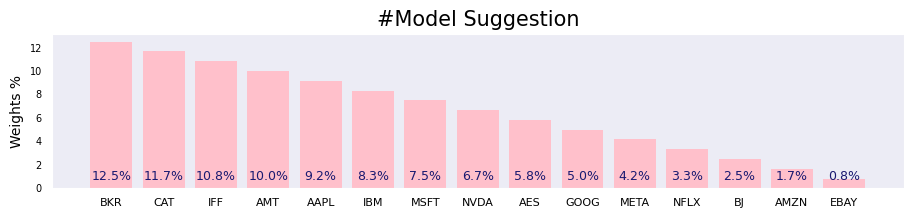

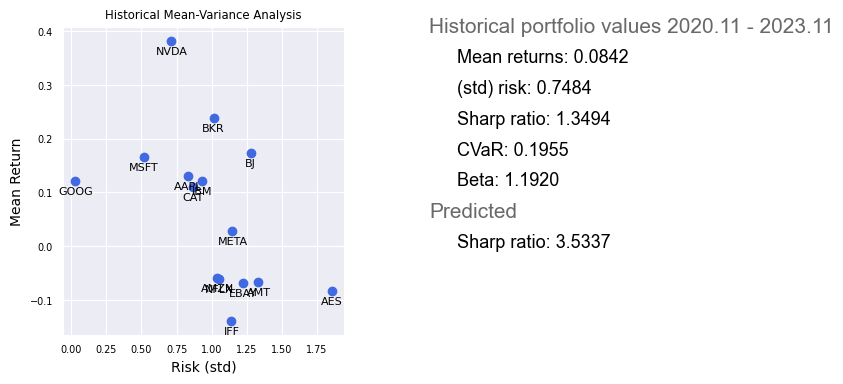

In [388]:
get_graph(tickers_res[int(top3index[0])], composed_data[int(top3index[0]), :PORTFOLIO_SIZE], '#Model Suggestion')
plt_fnd(composed_data[int(top3index[0])], tickers_res[int(top3index[0])], prediction[int(top3index[0])])


In [150]:
si1 = sorted_iterator[-1]
si2 = sorted_iterator[-2]
si3 = sorted_iterator[-3]

print(f"#1 {tickers_res[si1]}")
print(f"With weigth {composed_data[si1, :PORTFOLIO_SIZE]*100}")
print(f"Historical mean {composed_data[si1, -4]}")
print(f"Historical std {composed_data[si1, -3]}")
print(f"Historical sharp {composed_data[si1, -2]}")
print(f"Expected sharp {new[si1]}")


#1 ['GOOG' 'META' 'NFLX' 'BJ' 'AMZN' 'EBAY' 'BKR' 'CAT' 'IFF' 'AMT' 'AAPL'
 'IBM' 'MSFT' 'NVDA' 'AES']
With weigth [ 5.          4.16666667  3.33333333  2.5         1.66666667  0.83333333
 12.5        11.66666667 10.83333333 10.          9.16666667  8.33333333
  7.5         6.66666667  5.83333333]
Historical mean -0.02174292534921433
Historical std 0.007120979606109518
Historical sharp 0.05154792803143819
Expected sharp 0.6557818878173828


In [151]:
print(f"#2 {tickers_res[si2]}")
print(f"With weigth {composed_data[si2, :PORTFOLIO_SIZE]*100}")
print(f"Historical mean {composed_data[si2, -4]}")
print(f"Historical std {composed_data[si2, -3]}")
print(f"Historical sharp {composed_data[si2, -2]}")
print(f"Expected sharp {new[si2]}")

#2 ['GOOG' 'META' 'NFLX' 'BJ' 'AMZN' 'EBAY' 'BKR' 'CAT' 'IFF' 'AMT' 'AAPL'
 'IBM' 'MSFT' 'NVDA' 'AES']
With weigth [12.5         0.83333333  1.66666667  2.5         3.33333333  4.16666667
  5.          5.83333333  6.66666667  7.5         8.33333333  9.16666667
 10.         10.83333333 11.66666667]
Historical mean -0.04505596253490726
Historical std 0.006638516564261928
Historical sharp 0.0544048014661462
Expected sharp 0.6531363952636718


In [152]:
print(f"#3 {tickers_res[si3]}")
print(f"With weigth {composed_data[si3, :PORTFOLIO_SIZE]*100}")
print(f"Historical mean {composed_data[si3, -4]}")
print(f"Historical std {composed_data[si3, -3]}")
print(f"Historical sharp {composed_data[si3, -2]}")
print(f"Expected sharp {new[si3]}")

#3 ['GOOG' 'META' 'NFLX' 'BJ' 'AMZN' 'EBAY' 'BKR' 'CAT' 'IFF' 'AMT' 'AAPL'
 'IBM' 'MSFT' 'NVDA' 'AES']
With weigth [ 2.5         3.33333333  4.16666667  5.          5.83333333  6.66666667
  7.5         8.33333333  9.16666667 10.         10.83333333 11.66666667
 12.5         0.83333333  1.66666667]
Historical mean -0.05145364794247551
Historical std 0.005661694313098743
Historical sharp 0.04922234491609556
Expected sharp 0.6526805389404297


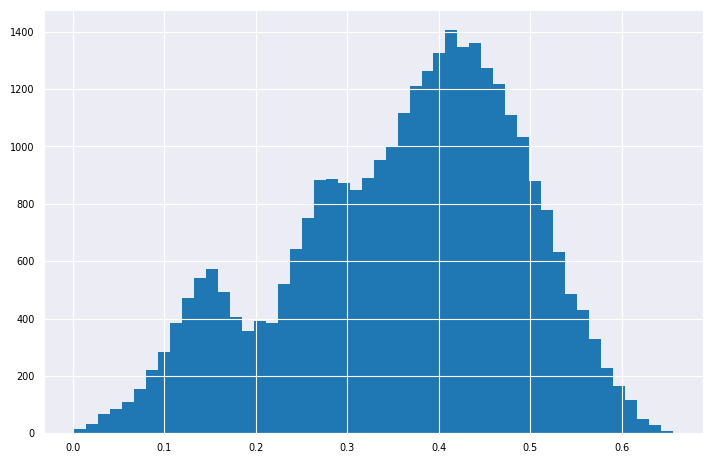

In [133]:
plt.hist(new, bins=50)
plt.show()